In [ ]:
from torchvision import datasets
import torch
data_folder = '/content/' # This can be any directory you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

In [ ]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [ ]:
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
batch_size = 16

In [ ]:
tr_images.shape, val_images.shape, torch.unique(tr_targets,return_counts=True), torch.unique(val_targets,return_counts=True)

(torch.Size([60000, 28, 28]),
 torch.Size([10000, 28, 28]),
 (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
  tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])),
 (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
  tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])))

In [ ]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,1,28,28)

#         print(x.shape)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]        
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

In [ ]:
class TMDLayer(nn.Module):
    def __init__(
        self,
        in_features = 100,
        L_latent = 16,
        epsilon = 0.25
    ):
        super().__init__()
        
        # what should be the dimension here? should this be user input?

        self.pi_list = nn.Sequential(nn.Linear(L_latent, in_features), 
                                                    nn.ReLU(),
                                                    nn.Linear(in_features, 1),
                                                    nn.Sigmoid())
        self.dt = nn.Parameter(torch.FloatTensor([0.1]))

        self.epsilon = epsilon
        self.proj_list = nn.Sequential(nn.Linear(in_features, L_latent))
    

    def TMD_map(self, x):
        # input x if of size [B, N, d]

        # print(x.shape)
        
        n,c,h,want = x.shape
        x = x.view(1,n,-1)

        x = self.proj_list(x)
        # L = construct from pe

        i_minus_j = x.unsqueeze(2) - x.unsqueeze(1)
        K_epsilon = torch.exp(-1 / (4 * self.epsilon) * (i_minus_j ** 2).sum(dim=3))

        ### construct TMD
        q_epsilon_tilde = K_epsilon.sum(dim=2)
        D_epsilon_tilde = torch.diag_embed(self.pi_list(x).squeeze(2) / q_epsilon_tilde)
        K_tilde = K_epsilon.bmm(D_epsilon_tilde)
        D_tilde = torch.diag_embed(K_tilde.sum(dim=2) +
                                   1e-5 * torch.ones(K_tilde.shape[0], K_tilde.shape[1]).to(x.device))
        L = 1 / self.epsilon * (torch.inverse(D_tilde).bmm(K_tilde)) - torch.eye(K_tilde.shape[1]).to(
            x.device).unsqueeze(0).repeat(x.shape[0], 1, 1)
        return L

        
    def forward(self, x, f):
        L = self.TMD_map(x).squeeze(0)

        target = f(x)
        #target = target.view(2,)
        #print(target.shape, L.shape)
        target = (target + self.dt*torch.matmul(L, target))

        return target

class FMNISTModel(nn.Module):
    def __init__(self, init_tmd = False):
        super().__init__()
        self.init_tmd = init_tmd 

       
        self.tmd_layer = TMDLayer(
            in_features = 28*28,
            L_latent = 16,
            epsilon = 0.25)
        

        self.prim = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3200, 256),
            nn.ReLU()
        )


        self.second = nn.Sequential(
            nn.Linear(256, 10)
        )

        #self.third = nn.Linear(256, 10)

        self.secondary_layer = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3200, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

           
    def forward(self, x):
        #(b, d ,n)

        if self.init_tmd:
          #print()
          x =  self.tmd_layer(x, self.secondary_layer)
          # x = self.second(x)
          #x = self.third(x)
        else:
          x = self.secondary_layer(x)
        
        
        return x
    
    
    
from torch.optim import SGD, Adam

def get_model(tmd_init=False):
    model_final = FMNISTModel(tmd_init).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model_final.parameters(), lr=1e-3)
    return model_final, loss_fn, optimizer

def train_batch(x, y, model_final, opt, loss_fn):
    
    prediction = model_final(x)
    batch_loss = loss_fn(prediction, y)
    opt.zero_grad()
    batch_loss.backward()
    opt.step()
    
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model_final):
    model_final.eval()
    prediction = model_final(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()   
def get_data():     
    train = FMNISTDataset(tr_images, tr_targets)     
    trn_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)     
    val_dl = DataLoader(val, batch_size=batch_size, shuffle=True)
    return trn_dl, val_dl

@torch.no_grad()
def val_loss(x, y, model_final):
    model_final.eval()
    prediction = model_final(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()


In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
from torchsummary import summary


In [ ]:
#Without Tmd Layer
summary(model, (1,28,28));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]             640
         MaxPool2d-2           [-1, 64, 13, 13]               0
              ReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4          [-1, 128, 11, 11]          73,856
         MaxPool2d-5            [-1, 128, 5, 5]               0
              ReLU-6            [-1, 128, 5, 5]               0
           Flatten-7                 [-1, 3200]               0
            Linear-8                  [-1, 256]         819,456
              ReLU-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.69
Params size (MB): 3.42
Estimated T

In [ ]:

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(25):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    print("Train train_epoch_loss Loss:", train_epoch_loss)
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        # print("Train Accuracy:", is_correct)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    print("train_epoch_accuracy:", train_epoch_accuracy)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
        # print("Validation Loss:", validation_loss)
    val_epoch_accuracy = np.mean(val_is_correct)

    print("val_epoch_accuracy:", val_epoch_accuracy) 
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
Train train_epoch_loss Loss: 0.14260962793297755
train_epoch_accuracy: 0.95665
val_epoch_accuracy: 0.75
1
Train train_epoch_loss Loss: 0.12242856530949163
train_epoch_accuracy: 0.9648
val_epoch_accuracy: 0.875
2
Train train_epoch_loss Loss: 0.10572728584813691
train_epoch_accuracy: 0.9678666666666667
val_epoch_accuracy: 0.9375
3
Train train_epoch_loss Loss: 0.0907904865162253
train_epoch_accuracy: 0.9726333333333333
val_epoch_accuracy: 1.0
4
Train train_epoch_loss Loss: 0.07920112143618559
train_epoch_accuracy: 0.9762333333333333
val_epoch_accuracy: 1.0


In [ ]:
trn_dl, val_dl = get_data()
model_final, loss_fn_w, optimizer_w = get_model(tmd_init=True)
summary(model_final,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 2, 16]          12,560
            Linear-2               [-1, 2, 784]          13,328
              ReLU-3               [-1, 2, 784]               0
            Linear-4                 [-1, 2, 1]             785
           Sigmoid-5                 [-1, 2, 1]               0
            Conv2d-6           [-1, 64, 26, 26]             640
         MaxPool2d-7           [-1, 64, 13, 13]               0
              ReLU-8           [-1, 64, 13, 13]               0
            Conv2d-9          [-1, 128, 11, 11]          73,856
        MaxPool2d-10            [-1, 128, 5, 5]               0
             ReLU-11            [-1, 128, 5, 5]               0
          Flatten-12                 [-1, 3200]               0
           Linear-13                  [-1, 256]         819,456
             ReLU-14                  [

In [ ]:

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model_final, optimizer_w, loss_fn_w)
        
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    print("Train train_epoch_loss Loss:", train_epoch_loss)
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model_final)
        # print("Train Accuracy:", is_correct)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    print("train_epoch_accuracy:", train_epoch_accuracy)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model_final)
        validation_loss = val_loss(x, y, model_final)
        # print("Validation Loss:", validation_loss)
    val_epoch_accuracy = np.mean(val_is_correct)

    print("val_epoch_accuracy:", val_epoch_accuracy) 
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
Train train_epoch_loss Loss: 0.16029178557543394
train_epoch_accuracy: 0.9549666666666666
val_epoch_accuracy: 0.875
1
Train train_epoch_loss Loss: 0.14102125020263873
train_epoch_accuracy: 0.95155
val_epoch_accuracy: 0.9375
2
Train train_epoch_loss Loss: 0.12636449184493784
train_epoch_accuracy: 0.9633666666666667
val_epoch_accuracy: 0.9375
3
Train train_epoch_loss Loss: 0.11020818065623553
train_epoch_accuracy: 0.9618
val_epoch_accuracy: 1.0
4
Train train_epoch_loss Loss: 0.10109672631311988
train_epoch_accuracy: 0.9691
val_epoch_accuracy: 1.0


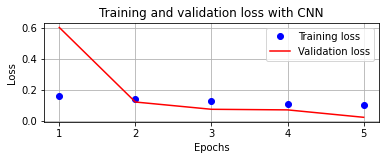

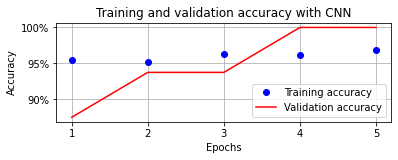

In [ ]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

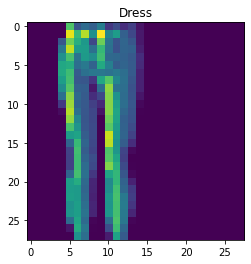

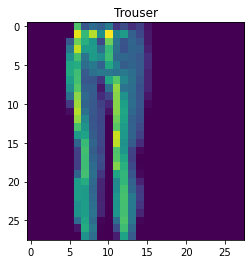

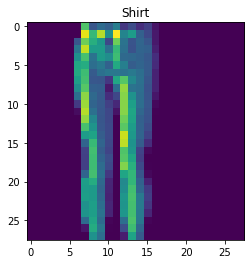

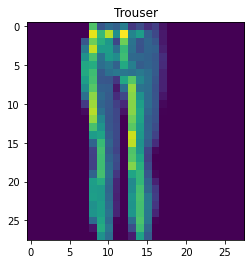

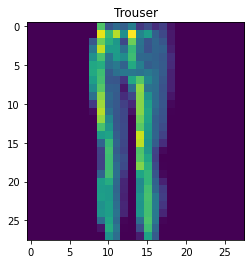

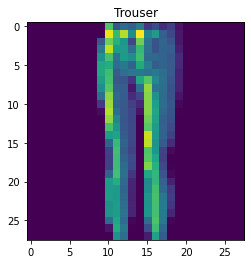

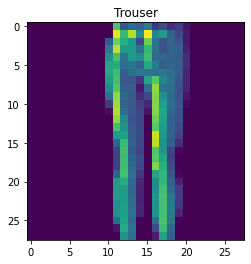

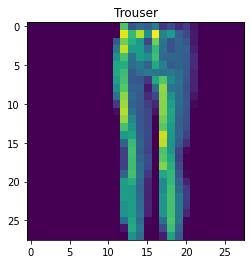

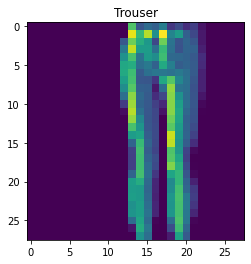

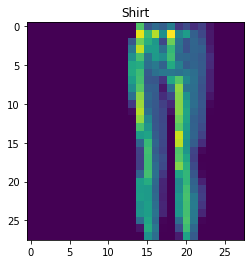

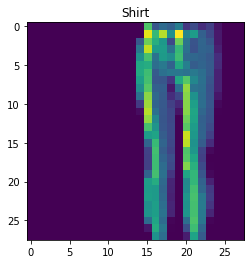

In [ ]:
preds = []
ix = 24335
for px in range(-5,6):
    img = tr_images[ix]/255.
    img = img.view(28, 28)
    img2 = np.roll(img, px, axis=1)
    img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
    # print(img3.shape)
    np_output = model(img3).cpu().detach().numpy()
    pred = np.exp(np_output)/np.sum(np.exp(np_output))
    preds.append(pred)
    plt.imshow(img2)
    plt.title(fmnist.classes[pred[0].argmax()])
    plt.show()

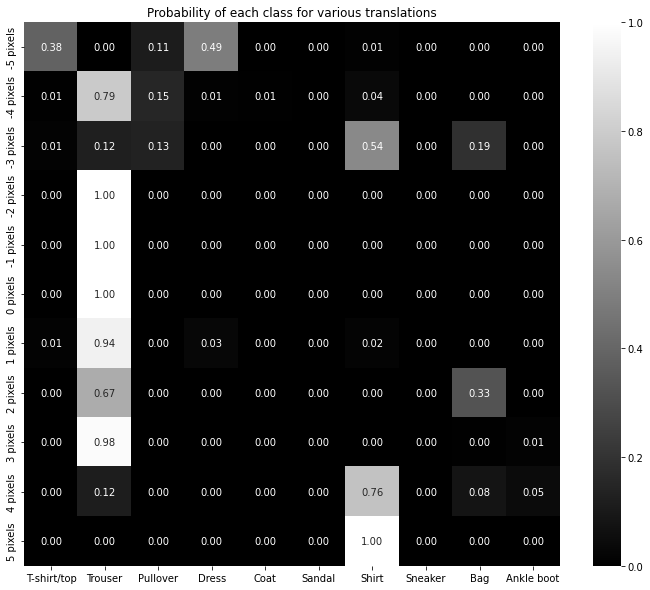

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds).reshape(11,10), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')


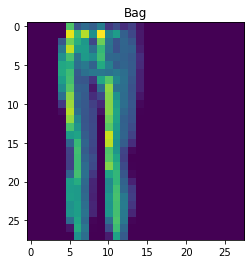

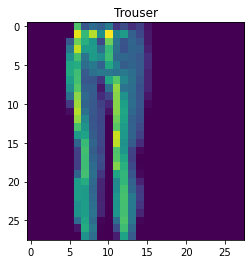

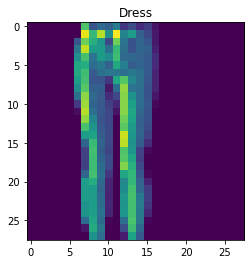

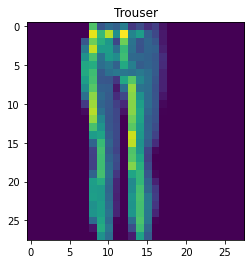

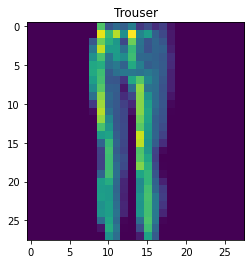

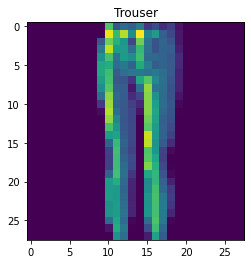

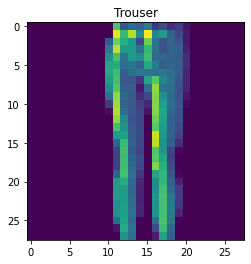

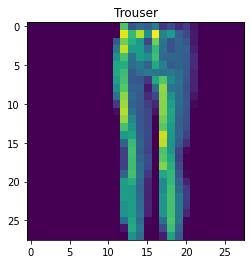

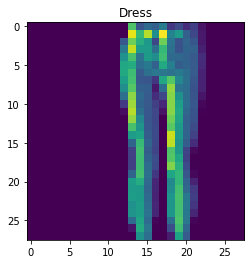

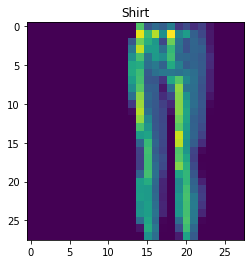

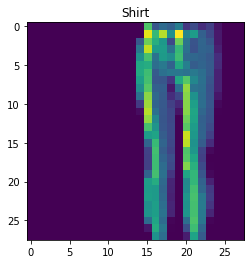

In [ ]:
preds_tmd = []
ix = 24335
for px in range(-5,6):
    img = tr_images[ix]/255.
    img = img.view(28, 28)
    img2 = np.roll(img, px, axis=1)
    img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
    # print(img3.shape)
    np_output = model_final(img3).cpu().detach().numpy()
    pred = np.exp(np_output)/np.sum(np.exp(np_output))
    preds_tmd.append(pred)
    plt.imshow(img2)
    plt.title(fmnist.classes[pred[0].argmax()])
    plt.show()

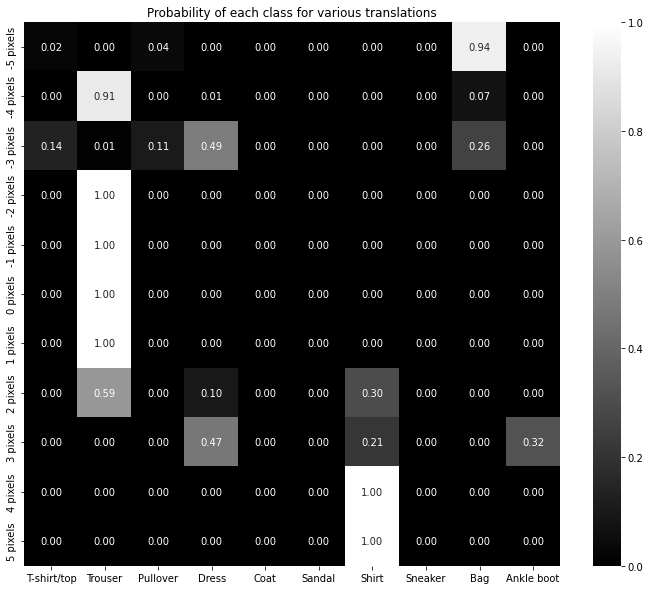

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds_tmd).reshape(11,10), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')


In [ ]:
%%capture
!pip install -U imgaug

In [ ]:
import imgaug.augmenters as iaa
def to_numpy(tensor):
    return tensor.cpu().detach().numpy()

Text(0.5, 1.0, 'Original image Ankle boot')

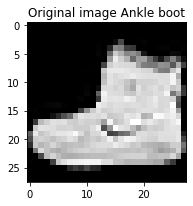

In [ ]:
plt.figure(figsize=(20,20))

# plt.imshow(img2)


plt.subplot(161)

tr_img = (tr_images[0]/255).view(-1,1,28,28).to(device)
np_output = model(tr_img).cpu().detach().numpy()

pred = np.exp(np_output)/np.sum(np.exp(np_output))

plt.imshow(tr_images[0], cmap='gray')

plt.title('Original image '+ fmnist.classes[pred[0].argmax()])




In [ ]:
def add_gaussian_noise(image_in, noise_sigma):
    temp_image = np.float64(np.copy(image_in))

    h = temp_image.shape[0]
    w = temp_image.shape[1]
    noise = np.random.randn(h, w) * noise_sigma

    noisy_image = np.zeros(temp_image.shape, np.float64)
    if len(temp_image.shape) == 2:
        noisy_image = temp_image + noise
    else:
        noisy_image[:,:,0] = temp_image[:,:,0] + noise
        noisy_image[:,:,1] = temp_image[:,:,1] + noise
        noisy_image[:,:,2] = temp_image[:,:,2] + noise

    return noisy_image

def get_reconstructed_image(raw):
    img = raw.clip(0, 255)
    img = img.astype('uint8')
    #img = Image.fromarray(img)
    return img

noisy_img = []

for i in range(0,len(val_images)):
  noisy_img.append(get_reconstructed_image(add_gaussian_noise(val_images[i],15)))
noisy_img = np.array(noisy_img)

val = FMNISTDataset(torch.tensor(noisy_img), val_targets)     
ldr = DataLoader(val, batch_size=len(noisy_img), shuffle=True)

for ix, batch in enumerate(iter(ldr)):
  x, y = batch
  val_is_correct = accuracy(x, y, model)
  val_is_correct_tmd = accuracy(x, y, model_final)
  validation_loss = val_loss(x, y, model)
  # print("Validation Loss:", validation_loss)

val_epoch_accuracy = np.mean(val_is_correct)

val_epoch_accuracy_tmd = np.mean(val_is_correct_tmd)

print("val_epoch_accuracy:", val_epoch_accuracy) 
print("val_epoch_accuracy_tmd:", val_epoch_accuracy_tmd) 


val_epoch_accuracy: 0.8775
val_epoch_accuracy_tmd: 0.8751


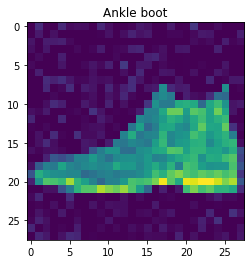

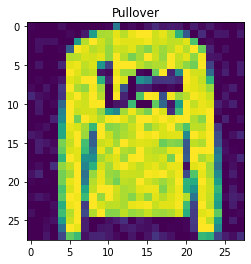

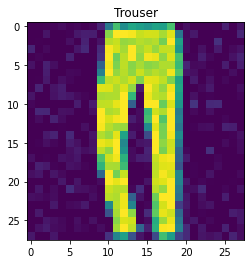

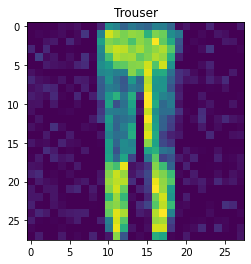

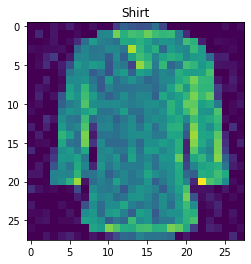

In [ ]:
for i in range(5):
  plt.imshow(noisy_img[i])
  plt.title(fmnist.classes[val_targets[i]])
  plt.show()

In [ ]:
from random import *

img_sp = []
for i in range(0,len(val_images)):
  prob = uniform(0.0,0.03)
  img = to_numpy(val_images[i])
  rnd = np.random.rand(img.shape[0],img.shape[1])
  noisy = img.copy()
  noisy[rnd < prob] = 0
  noisy[rnd > 1 - prob] = 255
  noisy = get_reconstructed_image(noisy)
  img_sp.append(noisy)

img_sp = torch.tensor(np.array(img_sp))

val = FMNISTDataset(img_sp, val_targets)     
ldr = DataLoader(val, batch_size=len(img_sp), shuffle=True)

val_epoch_accuracy = 0

for ix, batch in enumerate(iter(ldr)):
  x, y = batch
  val_is_correct = accuracy(x, y, model)
  val_is_correct_tmd = accuracy(x, y, model_final)
  validation_loss = val_loss(x, y, model)
  # print("Validation Loss:", validation_loss)

val_epoch_accuracy = np.mean(val_is_correct)

val_epoch_accuracy_tmd = np.mean(val_is_correct_tmd)

print("val_epoch_accuracy:", val_epoch_accuracy) 
print("val_epoch_accuracy_tmd:", val_epoch_accuracy_tmd) 

val_epoch_accuracy: 0.8279
val_epoch_accuracy_tmd: 0.8256


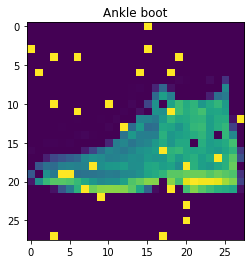

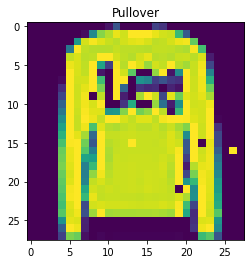

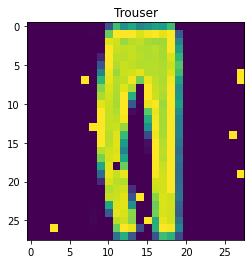

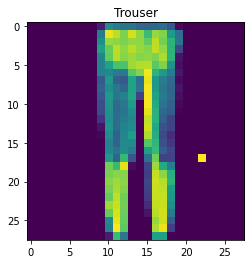

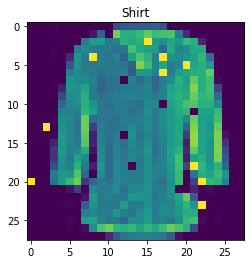

In [ ]:
for i in range(5):
  plt.imshow(img_sp[i])
  plt.title(fmnist.classes[val_targets[i]])
  plt.show()


In [ ]:
import cv2

img_blur = []
for i in range(0,len(val_images)):
  prob = uniform(0,5)
  img = to_numpy(val_images[i])
  blur = cv2.GaussianBlur(img,(3,3),prob)
  blur = get_reconstructed_image(blur)
  img_blur.append(blur)

img_blur = torch.tensor(np.array(img_blur))

val = FMNISTDataset(img_blur, val_targets)     
ldr = DataLoader(val, batch_size=len(img_blur), shuffle=True)

val_epoch_accuracy = 0

for ix, batch in enumerate(iter(ldr)):
  x, y = batch
  val_is_correct = accuracy(x, y, model)
  val_is_correct_tmd = accuracy(x, y, model_final)
  validation_loss = val_loss(x, y, model)
  # print("Validation Loss:", validation_loss)

val_epoch_accuracy = np.mean(val_is_correct)

val_epoch_accuracy_tmd = np.mean(val_is_correct_tmd)

print("val_epoch_accuracy:", val_epoch_accuracy) 
print("val_epoch_accuracy_tmd:", val_epoch_accuracy_tmd) 


val_epoch_accuracy: 0.8141
val_epoch_accuracy_tmd: 0.8412


In [ ]:
img_speckle = []
for i in range(0,len(val_images)):
  img = to_numpy(val_images[i])
  gauss = np.random.rand(img.shape[0],img.shape[1])
  gauss = gauss.reshape(img.shape[0],img.shape[1])
  speckle = img + gauss*img
  speckle = get_reconstructed_image(speckle)
  img_speckle.append(speckle)
img_speckle = torch.tensor(np.array(img_speckle))

val = FMNISTDataset(img_speckle, val_targets)     
ldr = DataLoader(val, batch_size=len(img_speckle), shuffle=True)

val_epoch_accuracy = 0

for ix, batch in enumerate(iter(ldr)):
  x, y = batch
  val_is_correct = accuracy(x, y, model)
  val_is_correct_tmd = accuracy(x, y, model_final)
  validation_loss = val_loss(x, y, model)
  # print("Validation Loss:", validation_loss)

val_epoch_accuracy = np.mean(val_is_correct)

val_epoch_accuracy_tmd = np.mean(val_is_correct_tmd)

print("val_epoch_accuracy:", val_epoch_accuracy) 
print("val_epoch_accuracy_tmd:", val_epoch_accuracy_tmd) 

val_epoch_accuracy: 0.8586
val_epoch_accuracy_tmd: 0.8575


In [ ]:
# generating the kernel
img_mot = []
for i in range(0,len(val_images)):
  size = int(uniform(1,10))
  kernel_motion_blur = np.zeros((size, size))
  kernel_motion_blur[int((size-1)/2), :] = np.ones(size)
  kernel_motion_blur = kernel_motion_blur / size
  img = to_numpy(val_images[i])
  output = cv2.filter2D(img, -1, kernel_motion_blur)
  img_mot.append(output)
img_mot = torch.tensor(np.array(img_mot))
val = FMNISTDataset(img_mot, val_targets)     
dl = DataLoader(val, batch_size=len(img_mot), shuffle=True)

val_epoch_accuracy = 0

for ix, batch in enumerate(iter(dl)):
  x, y = batch
  val_is_correct = accuracy(x, y, model)
  val_is_correct_tmd = accuracy(x, y, model_final)
  validation_loss = val_loss(x, y, model)
  # print("Validation Loss:", validation_loss)

val_epoch_accuracy = np.mean(val_is_correct)

val_epoch_accuracy_tmd = np.mean(val_is_correct_tmd)

print("val_epoch_accuracy:", val_epoch_accuracy) 
print("val_epoch_accuracy_tmd:", val_epoch_accuracy_tmd) 

val_epoch_accuracy: 0.6534
val_epoch_accuracy_tmd: 0.6825


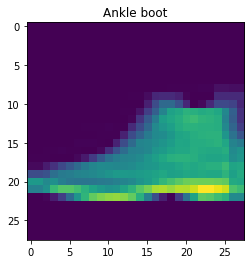

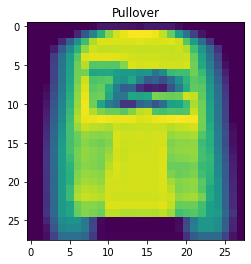

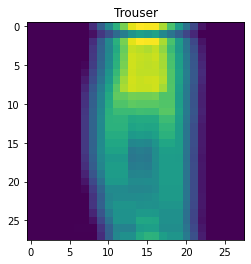

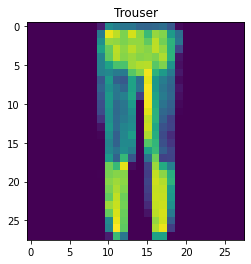

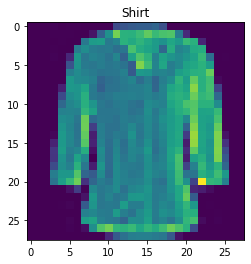

In [ ]:

for i in range(5):
  plt.imshow(img_mot[i])
  plt.title(fmnist.classes[val_targets[i]])
  plt.show()